In [1]:
# ! pip install mxnet
# ! pip install gluonnlp pandas tqdm
# ! pip install sentencepiece
# ! pip install transformers==3.0.2
# ! pip install torch

In [2]:
# ! pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

In [3]:
# ! pip install gluonnlp

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook
import pandas as pd

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import BertModel

#GPU 사용 시
device = torch.device("cuda:0")

In [5]:
raw_train = pd.read_csv("df_final_training2.csv")
raw_test = pd.read_csv("df_final_validation2.csv")

In [6]:
def transform_rawdataset(raw_df):
    df = raw_df[["type","HS01","HS02","HS03"]]
    df = df.fillna('')
    return df

df_train_raw = transform_rawdataset(raw_train)
df_test_raw = transform_rawdataset(raw_test)

In [7]:
emo = ["분노","슬픔","불안","상처","당황","기쁨"]
emo_label = [0,1,2,3,4,5]
df_train_raw["emotion"] = df_train_raw["type"]
df_test_raw["emotion"] = df_test_raw["type"]

for i in range(1,7):
    df_train_raw.loc[df_train_raw["type"].isin([f"E{j}"for j in range(10*i,20*i)]),"emotion"] = emo_label[i-1]
    df_test_raw.loc[df_test_raw["type"].isin([f"E{j}"for j in range(10*i,20*i)]),"emotion"] = emo_label[i-1]


In [8]:
def preprocessing_dataset(raw_df):

    

    df_hs01 = raw_df[["HS01","emotion"]]
    df_hs02 = raw_df[["HS02","emotion"]]
    df_hs03 = raw_df[["HS03","emotion"]]
    df_hs03.drop(df_hs03[df_hs03["HS03"] == ''].index,inplace=True)

    df_hs01.columns = ["content","emotion"]
    df_hs02.columns = ["content","emotion"]
    df_hs03.columns = ["content","emotion"]

    return pd.concat([df_hs01,df_hs02,df_hs03],ignore_index=True)

df_train = preprocessing_dataset(df_train_raw)
df_test = preprocessing_dataset(df_test_raw)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


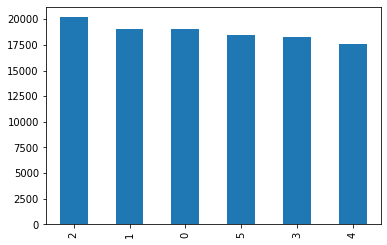

In [9]:
df_train["emotion"].value_counts().plot.bar()

In [10]:
df_train = df_train.values.tolist()
df_test = df_test.values.tolist()

In [11]:
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

bertmodel, vocab = get_pytorch_kobert_model()

tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer,vocab,lower=False)

using cached model. /content/.cache/kobert_v1.zip
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [12]:
# Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5  
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [13]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
   
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))
         

    def __len__(self):
        return (len(self.labels))

In [14]:
train_dataset = BERTDataset(df_train,0,1,tok,max_len,True,False)
test_dataset =  BERTDataset(df_test,0,1,tok,max_len,True,False)

In [15]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [16]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=6,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict=False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [17]:

#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
 
#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss() # 다중분류를 위한 대표적인 loss func

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    


In [ ]:
train_history=[]
test_history=[]
loss_history=[]
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
         
        #print(label.shape,out.shape)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
            train_history.append(train_acc / (batch_id+1))
            loss_history.append(loss.data.cpu().numpy())
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    #train_history.append(train_acc / (batch_id+1))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    test_history.append(test_acc / (batch_id+1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1761 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.8394699096679688 train acc 0.15625
epoch 1 batch id 201 loss 1.557979941368103 train acc 0.22807835820895522
epoch 1 batch id 401 loss 1.1825052499771118 train acc 0.3825592269326683
epoch 1 batch id 601 loss 0.856013298034668 train acc 0.4562707986688852
epoch 1 batch id 801 loss 1.3468869924545288 train acc 0.46502418851435706
epoch 1 batch id 1001 loss 1.3580905199050903 train acc 0.4665802947052947
epoch 1 batch id 1201 loss 1.4475466012954712 train acc 0.46816455037468774
epoch 1 batch id 1401 loss 1.5795860290527344 train acc 0.4588575124910778
epoch 1 batch id 1601 loss 1.4788721799850464 train acc 0.4478841349156777
epoch 1 train acc 0.44092558314768704


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/221 [00:00<?, ?it/s]

epoch 1 test acc 0.49509195737848494


  0%|          | 0/1761 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.1709144115447998 train acc 0.59375
epoch 2 batch id 201 loss 1.0257978439331055 train acc 0.619247512437811
epoch 2 batch id 401 loss 1.0120155811309814 train acc 0.6294420199501247
epoch 2 batch id 601 loss 0.7846503257751465 train acc 0.635841306156406
epoch 2 batch id 801 loss 1.2766152620315552 train acc 0.611228152309613
epoch 2 batch id 1001 loss 1.2217233180999756 train acc 0.594827047952048
epoch 2 batch id 1201 loss 1.2006828784942627 train acc 0.5855537052456287
epoch 2 batch id 1401 loss 1.5354541540145874 train acc 0.5688570663811563
epoch 2 batch id 1601 loss 1.401724100112915 train acc 0.5516181292941912
epoch 2 train acc 0.540761641113004


  0%|          | 0/221 [00:00<?, ?it/s]

epoch 2 test acc 0.5142474638738871


  0%|          | 0/1761 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.9732920527458191 train acc 0.609375
epoch 3 batch id 201 loss 0.9660695791244507 train acc 0.6671330845771144
